In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spop
import datetime
import matplotlib.dates as mdates
from scipy.interpolate import interp1d
import geopy.distance as gpd

## Load Data

In [3]:
def nan_helper(y):
    return np.isnan(y.data), lambda z: z.nonzero()[0]


In [4]:
springtime = xr.load_dataset("LiDAR/springtime_E06.nc")
llj_id = xr.load_dataset("LiDAR/springtime_E06_LLJs_2020.nc")
for var in ['U', 'V']:
    nans, x = nan_helper(springtime[var])
    springtime[var].data[nans] = np.interp(x(nans), x(~nans), springtime[var].data[~nans])
springtime

<xarray.Dataset>
Dimensions:        (t: 12523, z: 10)
Coordinates:
    datetime       (t) datetime64[ns] 2020-04-01 ... 2020-06-30T23:50:00
    height         (z) int64 18 38 58 78 98 118 138 158 178 198
Dimensions without coordinates: t, z
Data variables:
    windspeed      (t, z) float64 8.687 8.659 8.704 8.776 ... 1.135 1.133 1.178
    winddirection  (t, z) float64 81.16 79.44 81.96 81.17 ... 170.8 169.8 173.3
    temp           (t) float64 5.63 5.624 5.686 5.67 ... 22.41 22.5 22.5 22.44
    pressure       (t) float64 1.014e+03 1.014e+03 ... 1.012e+03 1.012e+03
    rel_humidity   (t) float64 70.9 70.54 70.93 71.31 ... 75.07 76.01 76.59
    waterT         (t) float64 8.29 8.293 8.297 8.3 ... 23.82 23.81 23.81 23.8
    U              (t, z) float64 -8.584 -8.513 -8.618 ... -0.2007 -0.1366
    V              (t, z) float64 -1.336 -1.587 -1.218 ... 1.121 1.115 1.17

In [7]:
cases = dict({
    'E05': dict({
        '20200602': [8928, 9792],   # 2020-06-02 to 2020-06-08
        '20200513': [6048, 6912],   # 2020-05-13 to 2020-05-19
        '20200403': [288, 1152],    # 2020-04-03 to 2020-04-09
        'allSpring': [0, -1]
    }),
    'E06': dict({
        '20200602': [8347, 9211],
        '20200513': [5467, 6331],
        '20200403': [288, 1152],    # 2020-04-03 to 2020-04-09
        'allSpring': [0, -1],
        '20210427': [85000, 85800] # from the full dataset
    })
})

In [8]:
Buoy = 'E06'
event = '20200403'
t_start = cases[Buoy][event][0] + 2*24*6 + 17*6
t_end = t_start + 18*6

u_data = springtime['U'].isel(t = slice(t_start, t_end))
v_data = springtime['V'].isel(t = slice(t_start, t_end))
datetime_data = springtime['datetime'].isel(t = slice(t_start, t_end))
z_data = springtime['height']
t_data = datetime_data['t']*600.0
T_data = springtime['temp'].isel(t = slice(t_start, t_end))

## Solve for the IO parameters

In [9]:
## DEFINE FUNCTIONS

lat = 39.68 # E06 NYSERDA
f = 2*7.2921e-5 * np.sin(lat/180 * np.pi) # coriolis term
T = 22.0
F = 2*np.pi / T / 3600

# u_ss, v_ss, A, phi are all vectors in z
def inertial_oscillation(u_ss, v_ss, A, phi, f, t):
    u = u_ss + A * np.sin(f*t + phi)
    v = v_ss + A * np.cos(f*t + phi)
    return (u, v)

def MSE(x, f, u_data, v_data, t_data):
    n = int(len(x) / 4)
    u_ss = x[0:n]
    v_ss = x[n:2*n]
    A = x[2*n:3*n]
    phi = x[3*n:]
    mse = 0.0
    for (i,t) in enumerate(t_data):
        (u_calc, v_calc) = inertial_oscillation(u_ss, v_ss, A, phi, f, t.data)
        mse += np.linalg.norm(u_data[i] - u_calc)**2 + np.linalg.norm(v_data[i] - v_calc)**2
    mse = mse / i
    return mse

In [10]:
print(F, f)
print(2*np.pi / 3600 / f)

7.933314781792407e-05 9.312000141950217e-05
18.74279666439958


In [11]:
# initial guess
u_ss = np.mean(np.asarray(u_data), axis=0)
v_ss = np.mean(np.asarray(v_data), axis=0)

Au = np.asarray(u_data - u_ss)
Av = np.asarray(v_data - v_ss)
A_all = np.sqrt(Au**2 + Av**2)
A = np.mean(A_all, axis=0)

sinarg = (u_data[:,:] - u_ss[:]) / A[:]
cosarg = (v_data[:,:] - v_ss[:]) / A[:]
tanarg = sinarg / cosarg
td = t_data.rename({'datetime':'Time'})
arg = np.arctan(tanarg) - f*t_data
phi = np.mean(arg, axis=0)
phi

<xarray.DataArray (z: 10)>
array([-3.03447316, -3.01282478, -2.93956137, -2.83068568, -2.65968734,
       -2.60257137, -2.67601383, -2.84792478, -2.94122928, -2.99518594])
Coordinates:
    height   (z) int64 18 38 58 78 98 118 138 158 178 198
Dimensions without coordinates: z

In [12]:
# Optimization
bnds = ((None, None),) * len(u_ss)
bnds = bnds + ((None, None),) * len(v_ss)
bnds = bnds + ((0, 20.0),) * len(A)
bnds = bnds + ((-np.pi + 1e-3, np.pi - 1e-3),) * len(phi)

x0 = np.concatenate([u_ss, v_ss, A, phi])
res = spop.minimize(MSE, x0, args=(f, u_data.data, v_data.data, t_data), bounds=bnds, method='L-BFGS-B', options={'maxiter':10})

n = int(len(res.x) / 4)
u_ss_sol = res.x[0:n]
v_ss_sol = res.x[n:2*n]
A_sol = res.x[2*n:3*n]
phi_sol = res.x[3*n:]

In [13]:
# Optimization
bnds = ((None, None),) * len(u_ss)
bnds = bnds + ((None, None),) * len(v_ss)
bnds = bnds + ((0, 20.0),) * len(A)
bnds = bnds + ((-np.pi + 1e-3, np.pi - 1e-3),) * len(phi)

x0 = np.concatenate([u_ss, v_ss, A, phi])
res2 = spop.minimize(MSE, x0, args=(F, u_data.data, v_data.data, t_data), bounds=bnds, method='L-BFGS-B', options={'maxiter':10})

n = int(len(res2.x) / 4)
u_ss_sol2 = res2.x[0:n]
v_ss_sol2 = res2.x[n:2*n]
A_sol2 = res2.x[2*n:3*n]
phi_sol2 = res2.x[3*n:]

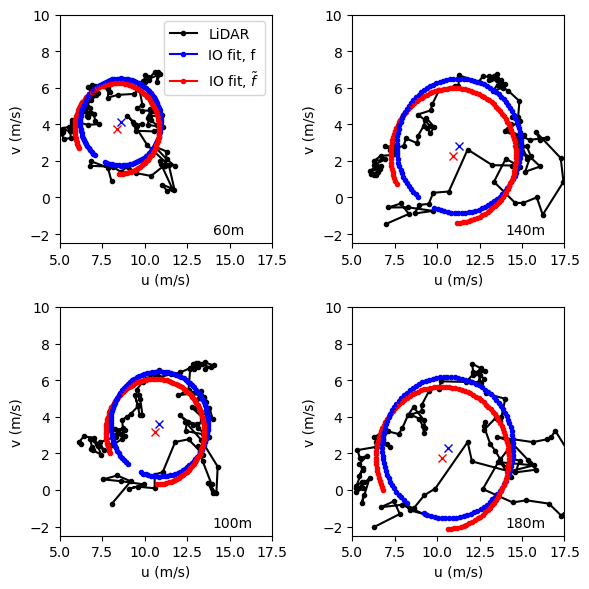

In [14]:
hlvls = [2, 4, 6, 8]
(fix, ax) = plt.subplots(nrows = 2, ncols = 2, figsize = (6,6))
for (j, hlvl) in enumerate(hlvls):
    jx = j % 2
    jy = j // 2
    ax[jx][jy].plot(u_data.isel(z = hlvl), v_data.isel(z = hlvl),'.-k')
    for t in t_data:
        [u, v] = inertial_oscillation(u_ss_sol, v_ss_sol, A_sol, phi_sol, f, t.data)
        ax[jx][jy].plot(u[hlvl], v[hlvl], '.-b')
        [u, v] = inertial_oscillation(u_ss_sol2, v_ss_sol2, A_sol2, phi_sol2, F, t.data)
        ax[jx][jy].plot(u[hlvl], v[hlvl], '.-r')
    ax[jx][jy].set_ylabel('v (m/s)')
    ax[jx][jy].set_xlabel('u (m/s)')
    ax[jx][jy].set_xlim([5, 17.5])
    ax[jx][jy].set_ylim([-2.5, 10.0])
    ax[jx][jy].annotate(str(z_data.data[hlvl]+2)+"m",(14, -2))
    ax[jx][jy].plot(u_ss_sol[hlvl], v_ss_sol[hlvl],'xb')
    ax[jx][jy].plot(u_ss_sol2[hlvl], v_ss_sol2[hlvl],'xr')
ax[0][0].legend(['LiDAR','IO fit, f',r'IO fit, $\tilde{f}$'])
plt.tight_layout()
plt.savefig('figures/fig12_April5_IOfits.png')

In [15]:
rms_u = np.zeros_like(u_ss)
rms_v = np.zeros_like(u_ss)
for (i, t) in enumerate(t_data):
    (u_calc, v_calc) = inertial_oscillation(u_ss_sol, v_ss_sol, A_sol, phi_sol, f, t.data)
    rms_u += (u_data[i] - u_calc)**2
    rms_v += (v_data[i] - v_calc)**2
rms_u = np.sqrt(rms_u / (i+1))
rms_v = np.sqrt(rms_v / (i+1))
rms_uv = np.sqrt(rms_u**2 + rms_v**2)

rms_u2 = np.zeros_like(u_ss)
rms_v2 = np.zeros_like(u_ss)
for (i, t) in enumerate(t_data):
    (u_calc, v_calc) = inertial_oscillation(u_ss_sol2, v_ss_sol2, A_sol2, phi_sol2, F, t.data)
    rms_u2 += (u_data[i] - u_calc)**2
    rms_v2 += (v_data[i] - v_calc)**2
rms_u2 = np.sqrt(rms_u2 / (i+1))
rms_v2 = np.sqrt(rms_v2 / (i+1))
rms_uv2 = np.sqrt(rms_u2**2 + rms_v2**2)


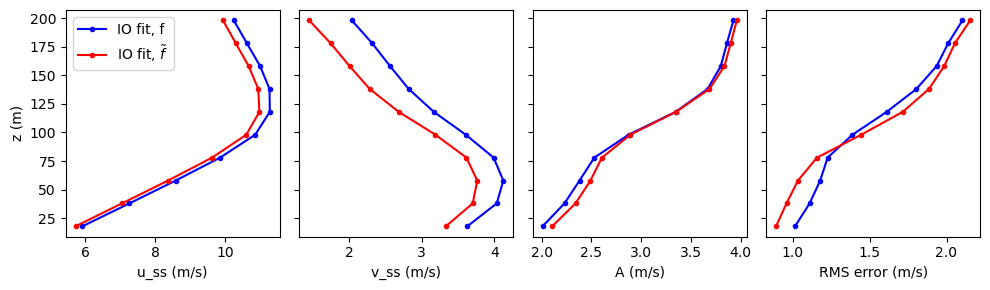

In [29]:
(fix, ax) = plt.subplots(ncols=4, sharey=True, figsize=(10, 3))
ax[0].plot(u_ss_sol, z_data, '.-b')
ax[0].plot(u_ss_sol2, z_data, '.-r')
ax[1].plot(v_ss_sol, z_data, '.-b')
ax[1].plot(v_ss_sol2, z_data, '.-r')
ax[2].plot(A_sol, z_data, '.-b')
ax[2].plot(A_sol2, z_data, '.-r')
ax[3].plot(rms_uv, z_data, '.-b')
ax[3].plot(rms_uv2, z_data, '.-r')

ax[0].legend(['IO fit, f',r'IO fit, $\tilde{f}$'])
ax[0].set_xlabel('u_ss (m/s)')
ax[1].set_xlabel('v_ss (m/s)')
ax[2].set_xlabel('A (m/s)')
ax[3].set_xlabel('RMS error (m/s)')
ax[0].set_ylabel('z (m)')
plt.tight_layout()

plt.savefig('figures/fig13a_April5_IO_params.png')

## Profiles

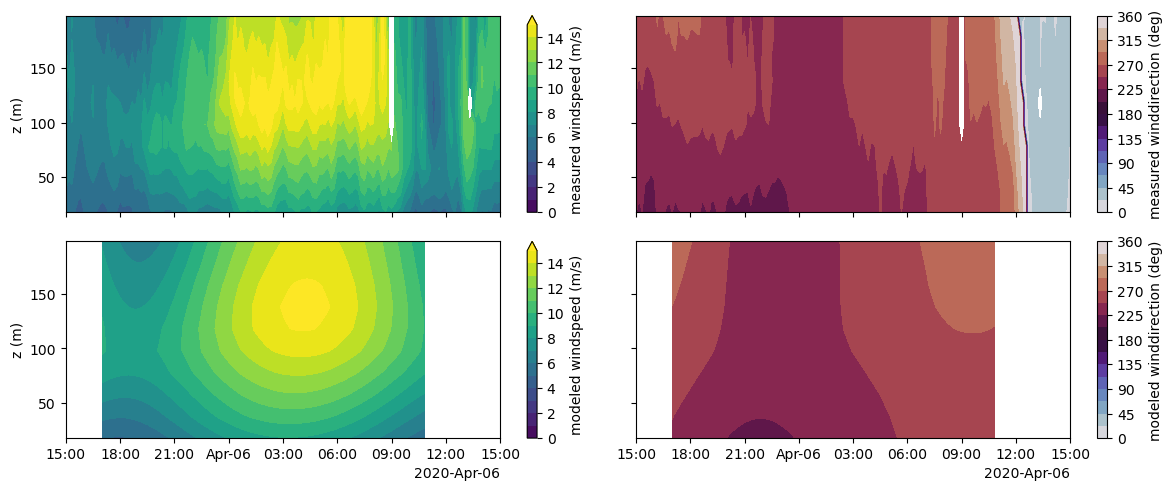

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, figsize=(12, 5))
clevels = np.linspace(0.0, 15.0, 16)
clevels2 = np.linspace(0.0, 360.0, 17)

ws = springtime['windspeed'].isel(t=slice(cases[Buoy][event][0], cases[Buoy][event][1]))
wd = springtime['winddirection'].isel(t=slice(cases[Buoy][event][0], cases[Buoy][event][1]))

(t, z) = np.meshgrid(ws['datetime'], ws['height'])
CS0 = ax[0][0].contourf(t.T,z.T,ws, clevels, extend='max')
CS1 = ax[0][1].contourf(t.T,z.T,wd, clevels2, cmap='twilight')
ax[0][0].set_xlim([np.datetime64('2020-04-05T15:00'), np.datetime64('2020-04-06T15:00')])
ax[0][0].set_ylabel('z (m)')
ax[1][0].set_ylabel('z (m)')

ws_io = np.zeros_like(u_data)
wd_io = np.zeros_like(u_data)
for (i, t) in enumerate(t_data):
    (u, v) = inertial_oscillation(u_ss_sol, v_ss_sol, A_sol, phi_sol, f, t.data)
    ws_io[i,:] = np.sqrt(u**2 + v**2)
    wd_io[i,:] = 270 - np.arctan(v/u)/np.pi*180

(t, z) = np.meshgrid(datetime_data, z_data)
CS2 = ax[1][0].contourf(t.T,z.T,ws_io, clevels, extend='max')
CS3 = ax[1][1].contourf(t.T,z.T,wd_io, clevels2, cmap='twilight')

fig.colorbar(CS0, ax=ax[0][0],label='measured windspeed (m/s)')
fig.colorbar(CS1, ax=ax[0][1],label='measured winddirection (deg)')
fig.colorbar(CS2, ax=ax[1][0],label='modeled windspeed (m/s)')
fig.colorbar(CS3, ax=ax[1][1],label='modeled winddirection (deg)')

ax[0][0].xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax[0][0].xaxis.get_major_locator()))
ax[0][1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax[0][1].xaxis.get_major_locator()))

plt.tight_layout()
plt.savefig('figures/fig14_April5_IO_timeheight.png')

## Ekman Taylor

In [18]:
def ekman_taylor(Ug0, Ugz, z, H, A):
    [ug, vg] = Ug0 + Ugz * z
    [ugz, vgz] = Ugz
    [ug0, vg0] = Ug0
    u0 = ((2+A)*ug0 + (1+A)*H*ugz - (A*vg0 - H*vgz)) / (1 + (1+A)**2)
    v0 = ((2+A)*vg0 + (1+A)*H*vgz + (A*ug0 - H*ugz)) / (1 + (1+A)**2)
    eta = z / H
    u = ug + np.exp(-eta)*((u0 - ug0)*np.cos(eta) + (v0 - vg0)*np.sin(eta))
    v = vg + np.exp(-eta)*((v0 - vg0)*np.cos(eta) - (u0 - ug0)*np.sin(eta))
    return [u, v]

In [19]:
def MSE_EK1(x, z, ugz, vgz, u_ss, v_ss):
    [ug0, vg0, H, A] = x
    uss_EK = np.zeros_like(u_ss)
    vss_EK = np.zeros_like(v_ss)
    for (i, z) in enumerate(z):
        (u, v) = ekman_taylor(np.array([ug0, vg0]), np.array([ugz, vgz]), z, H, A)
        uss_EK[i] = u
        vss_EK[i] = v
    mse = np.linalg.norm(uss_EK - u_ss)**2 + np.linalg.norm(vss_EK - v_ss)**2
    return mse

In [20]:
def MSE_EK2(x, z, u_ss, v_ss):
    [ug0, vg0, ugz, vgz, H, A] = x
    uss_EK = np.zeros_like(u_ss)
    vss_EK = np.zeros_like(v_ss)
    for (i, z) in enumerate(z):
        (u, v) = ekman_taylor(np.array([ug0, vg0]), np.array([ugz, vgz]), z, H, A)
        uss_EK[i] = u
        vss_EK[i] = v
    mse = np.linalg.norm(uss_EK - u_ss)**2 + np.linalg.norm(vss_EK - v_ss)**2
    return mse

Text(0, 0.5, 'z (m)')

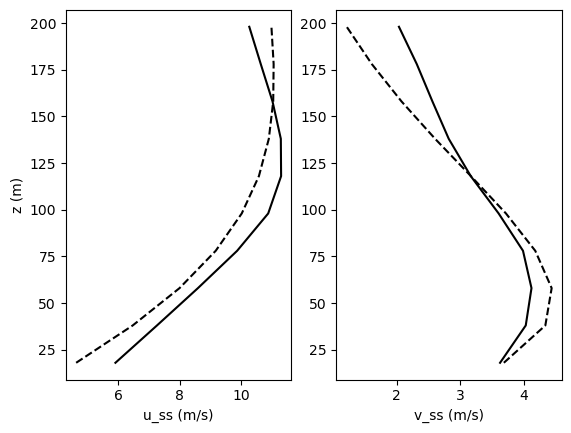

In [21]:
# Some initial guesses from just fiddling around
uss_EK = np.zeros_like(u_ss)
vss_EK = np.zeros_like(v_ss)
ugz = -0.003
vgz = -0.006
H = 80
A = 3
ug0 = 11.0
vg0 = 2
for (i,z) in enumerate(z_data.data):
    (uss_EK[i], vss_EK[i]) = ekman_taylor(np.array([ug0, vg0]), np.array([ugz, vgz]), z, H, A)
# initial guess
(fix, ax) = plt.subplots(ncols=2)
ax[0].plot(u_ss_sol, z_data,'-k')
ax[0].plot(uss_EK, z_data,'--k')
ax[1].plot(v_ss_sol, z_data,'-k')
ax[1].plot(vss_EK, z_data,'--k')
ax[0].set_xlabel('u_ss (m/s)')
ax[1].set_xlabel('v_ss (m/s)')
ax[0].set_ylabel('z (m)')
#plt.savefig('DynamicTrio/20200515_ssEK.png')

In [23]:
# with optiming the ugz, vgz
bnds = ((None, None),)
bnds = bnds + ((None, None),)
bnds = bnds + ((-0.1, 0.1),)
bnds = bnds + ((-0.1, 0.1),)
bnds = bnds + ((0.0, 400.0),)
bnds = bnds + ((0.0, 10.0),)
x0 = [ug0, vg0, ugz, vgz, H, A]
z = z_data.data
res = spop.minimize(MSE_EK2, x0, args=(z, u_ss_sol, v_ss_sol),bounds=bnds,method='L-BFGS-B')
[ug0, vg0, ugz, vgz, H, A] = res.x
[ug0, vg0, ugz, vgz, H, A]

# from running twice (to converge):
# [13.654985024485828,
#  -1.2863560262536278,
#  -0.021883246558418435,
#  0.011696093503345198,
#  98.05566307235053,
#  3.1237515557480533]

[13.654985024485828,
 -1.2863560262536278,
 -0.021883246558418435,
 0.011696093503345198,
 98.05566307235053,
 3.1237515557480533]

In [25]:
# without optiming the ugz, vgz -- see notebook `08-temperature_gradients.ipynb` for values
dTdx = -0.0135e-3
dTdy = 0.0182e-3
T = 9.72 + 273.15
g = 9.81
ugz2 = -g/f/T * dTdy
vgz2 = g/f/T * dTdx

bnds = ((None, None),)
bnds = bnds + ((None, None),)
bnds = bnds + ((0.0, 400.0),)
bnds = bnds + ((0.0, 10.0),)
x0 = [ug0, vg0, H, A]
z = z_data.data
res2 = spop.minimize(MSE_EK1, x0, args=(z, ugz2, vgz2, u_ss_sol, v_ss_sol),bounds=bnds,method='L-BFGS-B')
[ug02, vg02, H2, A2] = res2.x
[ug02, vg02, ugz2, vgz2, H2, A2]

# from running twice (to converge):
# [11.594024384166307,
#  2.0282564932400264,
#  -0.006778139940606575,
#  -0.005027741164735647,
#  86.33741052603284,
#  1.7095436362379042]

[11.594024384166307,
 2.0282564932400264,
 -0.006778139940606575,
 -0.005027741164735647,
 86.33741052603284,
 1.7095436362379042]

In [26]:
kappa = H**2 * f / 2
kappa2 = H2**2 * f / 2
print(kappa, kappa2)

0.4476703589237907 0.3470651574178142


In [27]:
theta0 = 300.0
dTdx = -vgz*f*theta0/g*1000
dTdy = ugz*f*theta0/g*1000
print(dTdx, dTdy)

-0.0333070410897289 -0.0623170627089676


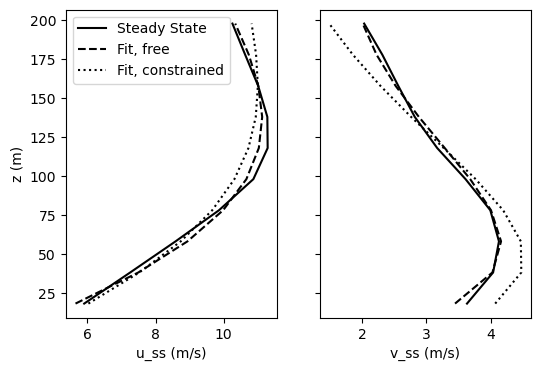

In [28]:
# Optimized solution
uss_EK = np.zeros_like(u_ss)
vss_EK = np.zeros_like(v_ss)
uss_EK2 = np.zeros_like(u_ss)
vss_EK2 = np.zeros_like(v_ss)
for (i,z) in enumerate(z_data.data):
    (uss_EK[i], vss_EK[i]) = ekman_taylor(np.array([ug0, vg0]), np.array([ugz, vgz]), z, H, A)
    (uss_EK2[i], vss_EK2[i]) = ekman_taylor(np.array([ug02, vg02]), np.array([ugz2, vgz2]), z, H2, A2)

(fix, ax) = plt.subplots(ncols=2, sharey=True, figsize=(6,4))
ax[0].plot(u_ss_sol, z_data,'-k')
ax[0].plot(uss_EK, z_data,'--k')
ax[0].plot(uss_EK2, z_data,':k')
ax[1].plot(v_ss_sol, z_data,'-k')
ax[1].plot(vss_EK, z_data,'--k')
ax[1].plot(vss_EK2, z_data,':k')
ax[0].legend(['Steady State','Fit, free', 'Fit, constrained'])
ax[0].set_xlabel('u_ss (m/s)')
ax[1].set_xlabel('v_ss (m/s)')
ax[0].set_ylabel('z (m)')
plt.savefig('figures/fig17a_April5_IO_EK.png')